rewrite with qiskit-nature 0.5:
https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html

In [1]:
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)

In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
problem = driver.run()
problem

In [3]:
hamiltonian = problem.hamiltonian
operators_secq = problem.second_q_ops()

In [4]:
# particle_number = hamiltonian.grouped_property_transformed.get_property("ParticleNumber")
# print(f"Hydrogen: {particle_number.num_alpha} alpha (spin up) electron, "
#       f"{particle_number.num_beta} beta (spin down) electron, {particle_number.num_spin_orbitals} spin orbitals")

In [5]:
# electronic_energy = hamiltonian.grouped_property_transformed.get_property("ElectronicEnergy")
# print(electronic_energy)

In [6]:
# electronic_energy_operator = operators_secq["ElectronicEnergy"]
# electronic_energy_operator.set_truncation(0)
# print(electronic_energy_operator.to_matrix())

In [7]:
# from qiskit_nature.converters.second_quantization import QubitConverter
# from qiskit_nature.operators.second_quantization import FermionicOp
# from qiskit_nature.mappers.second_quantization import JordanWignerMapper
# converter = JordanWignerMapper()
# qubit_converter = QubitConverter(converter)
# for label in ["+_0", "+_1", "+_2", "+_3", "+_4"]:
#     fermionic_operator = FermionicOp(label)
#     qubit_operator = qubit_converter.convert(fermionic_operator)
#     print(f"{label}: {qubit_operator}")

In [8]:
from qiskit_nature.second_q.mappers import QubitConverter, JordanWignerMapper
converter = JordanWignerMapper()  # also ParityMapper, BravyiKitaevMapper
qubit_converter = QubitConverter(converter, two_qubit_reduction=True)
# qubit_operator = qubit_converter.convert(electronic_energy_operator)
# print(qubit_operator)

In [9]:
# import os
# from pyscf import gto, scf
# from contextlib import suppress

# for filename in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
#     with suppress(FileNotFoundError):
#         os.remove(filename)

# atom_pyscf = [" ".join([str(val) for val in [name, *coordinates]]) for name, coordinates in molecule.geometry]
# molecule_pyscf = gto.M(atom=atom_pyscf)
# mf = scf.RHF(molecule_pyscf)
# mf.chkfile = "mf.hdf5"

# converged, ground_state_energy, mo_e, mo, mo_occ = scf.hf.kernel(mf)
# if converged:
#   print(f"PySCF restricted HF (RHF) converged ground-state energy: {ground_state_energy:.12f}")
# else:
#   print("PySCF restricted HF (RHF) ground-state computation failed to converge")

In [10]:
# import pyqmc.api as pyq
# import h5py

# pyq.OPTIMIZE("mf.hdf5",  # Construct a Slater-Jastrow wave function from the pyscf output
#     "optimized_wf.hdf5", # Store optimized parameters in this file.
#     nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
#     max_iterations=4,    # 4 optimization steps
#     verbose=False)

# with h5py.File("optimized_wf.hdf5") as f:
#     energies = f['energy']
#     errors = f['energy_error']
#     final_energy = energies[-1]
#     final_error = errors[-1]

#     if final_error < 0.1:
#         print("Iteration, Energy, Error")
#         for k, (energy, error) in enumerate(zip(energies, errors)):
#             print(f"{k:>2}:        {energy:.4f} {error:.4f}")
#         print(f"PyQMC Monte Carlo converged ground-state energy: {final_energy:.12f}, error: {final_error:.4f}")
#     else:
#         print("PyQMC Monte Carlo failed to converge")

In [11]:
# from qiskit import QuantumCircuit
# import numpy as np
# def u(theta):
#     unitary = QuantumCircuit(1)
#     unitary.p(np.pi*2*theta, 0)
#     return unitary

In [12]:
# from qiskit.algorithms import PhaseEstimation
# from qiskit.utils import QuantumInstance
# from qiskit import Aer

# n_qubits = 3
# quantum_instance = QuantumInstance(backend=Aer.get_backend('aer_simulator_statevector'))
# phase_estimation = PhaseEstimation(num_evaluation_qubits=n_qubits, quantum_instance=quantum_instance)

# state_in = QuantumCircuit(1)
# state_in.x(0)
# unitary = u(1/2 + 1/4 + 1/8)

# result = phase_estimation.estimate(unitary, state_in)

# print(f"Number of qubits: {n_qubits}, QPE phase estimate: {result.phase}")

In [13]:
from qiskit_nature.second_q.algorithms import NumPyMinimumEigensolverFactory, VQEUCCFactory
# from qiskit.algorithms import VQE
# from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.second_q.circuit.library import UCCSD

numpy_solver_factory = NumPyMinimumEigensolverFactory()
# ansatz?
# two_local_circuit = TwoLocal(rotation_blocks=['h', 'rx'], entanglement_blocks='cz',
#                       entanglement='full', reps=2, parameter_prefix='y')
vqe_ucc_solver_factory = VQEUCCFactory(estimator=Estimator(), ansatz=UCCSD(), optimizer=SLSQP())


qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)



In [14]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
import qiskit_nature.settings
from contextlib import contextmanager

# n_electrons = (particle_number.num_alpha, particle_number.num_beta)
# n_molecular_orbitals = particle_number.num_spin_orbitals // 2

n_electrons = 2
n_spatial_orbitals = 2

transformer = ActiveSpaceTransformer(num_electrons=n_electrons, num_spatial_orbitals=n_spatial_orbitals)
problem_transformed = transformer.transform(problem)

numpy_solver = numpy_solver_factory.get_solver(problem, qubit_converter)

ground_state_eigen_solver = GroundStateEigensolver(qubit_converter, numpy_solver)
ground_state = ground_state_eigen_solver.solve(problem_transformed)

print(ground_state)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [15]:
vqe_ucc_solver = vqe_ucc_solver_factory.get_solver(problem, qubit_converter)

ground_state_eigen_solver_vqe_ucc = GroundStateEigensolver(qubit_converter, vqe_ucc_solver)
ground_state = ground_state_eigen_solver_vqe_ucc.solve(problem_transformed)

print(ground_state)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894893]
    - computed part:      [0.0  0.0  1.38894893]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  -0.00000023]  Total: 0.00000023
                 (debye): [0.0  0.0  -0.00000058]  Total: 0.00000058
 


.....................

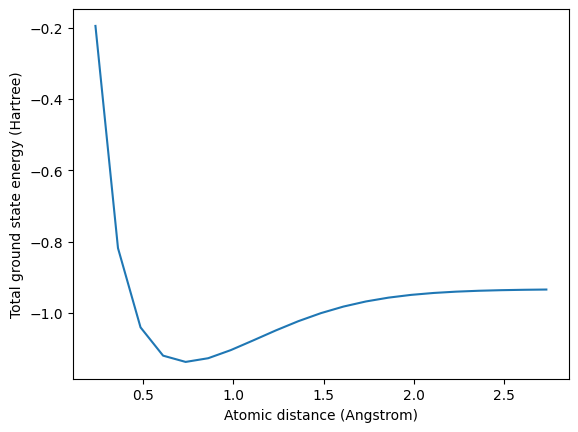

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qcomp_qchem.components import create_h2_molecule, calculate_ground_state_energy

distances = 0.735 + np.linspace(-0.5, 2, 21)
molecules = [create_h2_molecule(distance) for distance in distances]
ground_state_energies = np.array([calculate_ground_state_energy(molecule) for molecule in molecules])

plt.plot(distances, ground_state_energies)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Total ground state energy (Hartree)")
plt.show()